In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/Dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_1142.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_1006.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_817.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_765.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_508.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_257.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_328.wav
/kaggle/input/shl-intern-hiring-ass

In [2]:
train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv')
print(train_df.head())
print(train_df.info())


         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  444 non-null    object 
 1   label     444 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.1+ KB
None


## We'll extract MFCC features (Mel Frequency Cepstral Coefficients) from each .wav file using librosa.


In [3]:
import librosa
from tqdm import tqdm

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)

# Directory for audio files

In [4]:
audio_dir = '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/'

# Extract features for all training files

In [5]:
X = []
y = []

In [6]:
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(audio_dir, row['filename'])
    features = extract_features(file_path)
    X.append(features)
    y.append(row['label'])

100%|██████████| 444/444 [00:36<00:00, 12.05it/s]


In [7]:
X = np.array(X)
y = np.array(y)

# Use a simple regression model like RandomForest or GradientBoosting:

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [10]:
from sklearn.metrics import mean_squared_error
raw_preds = model.predict(X_val)
preds = np.clip(raw_preds, 0, 5)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.9576


# Now, we'll extract features from test audio files and generate grammar score predictions using your trained model.

In [11]:
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv')
test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/'

In [12]:
X_test = []
test_filenames = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(test_audio_dir, row['filename'])  # adjust to your actual column name if different
    features = extract_features(file_path)
    X_test.append(features)
    test_filenames.append(row['filename'])

100%|██████████| 204/204 [00:14<00:00, 13.74it/s]


In [13]:
from sklearn.preprocessing import StandardScaler

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(np.array(X_test))
test_preds = model.predict(X_test_scaled)


# Creating submission DataFrame and saving to submission.csv

In [14]:
test_preds = np.clip(model.predict(X_test), 0, 5)
submission = pd.DataFrame({
    'filename': test_filenames,
    'label': test_preds  
})

submission.to_csv('submission.csv', index=False)
print("✅ Submission file created: submission.csv")

✅ Submission file created: submission.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


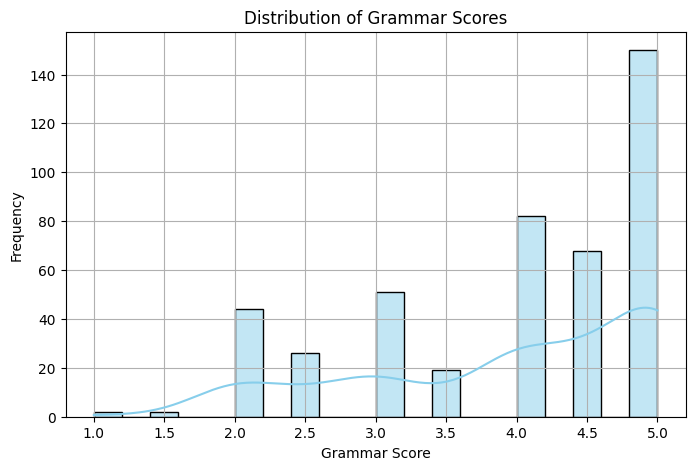

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(train_df['label'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
